In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, KFold
from sklearn import linear_model 
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error, mean_absolute_percentage_error, RocCurveDisplay
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, RobustScaler, StandardScaler, FunctionTransformer, LabelEncoder, OneHotEncoder, Binarizer, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA 
from sklearn.impute import SimpleImputer  
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel, RFE, RFECV 

# I - Analyse + data ingenering : 


In [2]:
df = pd.read_csv('./my_first_linear_reg/kc_house_data.csv')
pd.set_option('display.max_columns', None)
df = df.drop(columns=['id'])


In [3]:
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


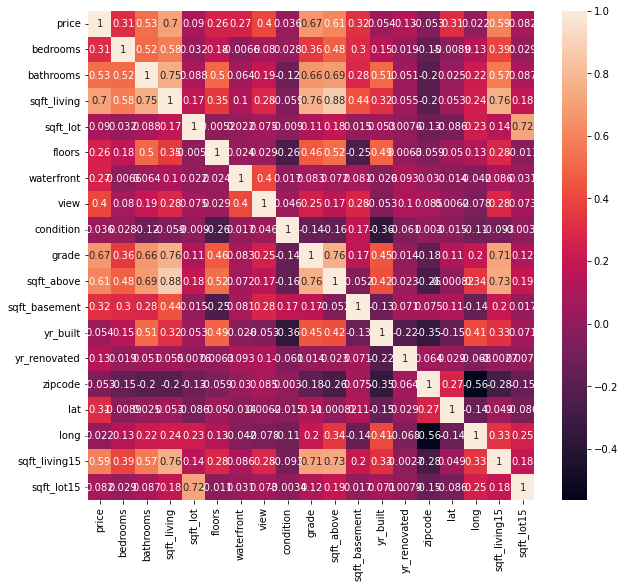

In [4]:
plt.figure(figsize=(10,9))
sns.heatmap(df.corr(), annot=True)
plt.show()

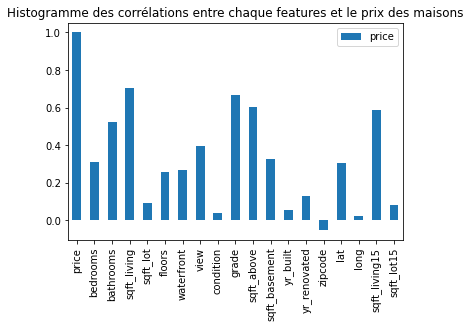

In [5]:
df.corr()[['price']].plot.bar()
plt.title('Histogramme des corrélations entre chaque features et le prix des maisons')
plt.show()

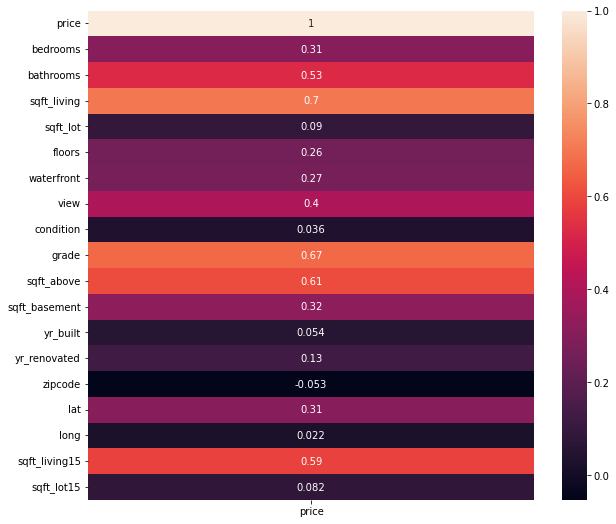

In [6]:
plt.figure(figsize=(10,9))
sns.heatmap(df.corr()[['price']], annot=True)
plt.show()

Sur ces deux précedentes images, on peut voir que plusieurs features semblent avoir un potentielle de correlation, et donc un potentielle d'importance dans mon modèle.

Je vais les ordonné en valeur absolue pour mieux visualisés ces données

Correlation en valeur absolue par ordre d'importance  :

In [7]:
np.abs(df.corr()[['price']].sort_values('price', ascending=False))

,price
price,1.000000
sqft_living,0.702035
grade,0.667434
sqft_above,0.605567
sqft_living15,0.585379
bathrooms,0.525138
view,0.397293
sqft_basement,0.323816
bedrooms,0.308350
lat,0.307003


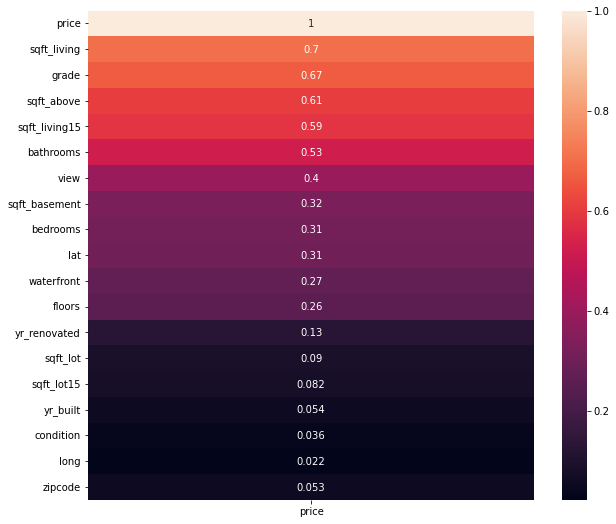

In [8]:
plt.figure(figsize=(10,9))
sns.heatmap(np.abs(df.corr()[['price']].sort_values('price', ascending=False)), annot=True)
plt.show()

La date ou le zipcode ne sont pas des valeur ordinales comparable aux autres. 
Si je veux profiter de la valeur de ces données, je pourrais les encoder afin de profiter de ces informations de manière catégorielles.


Certaine variables continue, comme la surface habitable est corrélé à 70%. 
Toute ces informations pourront être intéressente à prendre en compte pour mon modèle 

### - Pour la colonne : Zipcode 

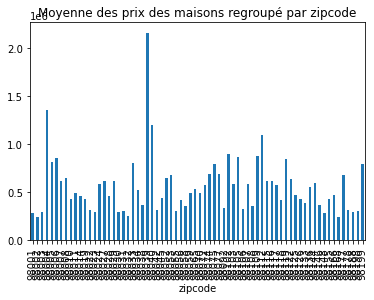

In [9]:
df.groupby('zipcode').mean()['price'].plot.bar()
plt.title('Moyenne des prix des maisons regroupé par zipcode')
plt.show()

#####  On peut voir que la moyenne des prix des maisons est différentes selon le zipcode. 
#####  Cette variable peut donc être ineteressante à prendre en compte dans mon modèle. 

### - Pour la colonne : Condition 

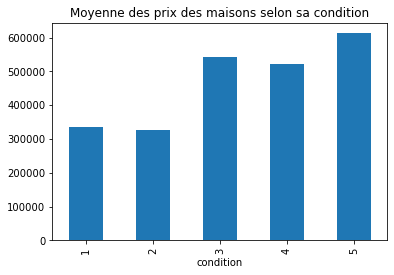

In [10]:
df.groupby('condition').mean()['price'].plot.bar()
plt.title('Moyenne des prix des maisons selon sa condition')
plt.show()

##### On peut voir que la moyenne des prix des maisons sont différentes selon la condition de la maison. 
##### Cette variable peut donc être ineteressante à prendre en compte dans mon modèle. 

# Feature Engenering 

In [11]:
# Mis a jour du format date
df['date'] = pd.to_datetime(df['date']).dt.year

# # Colonne bool si rénover il a moins de 12ans ou non. 
df['renoved_recently'] = df['date'] - df['yr_renovated'] 
df['renoved_recently'][df['renoved_recently'] < 12] = True
df['renoved_recently'][df['renoved_recently'] >= 12] = False

# # Je transforme la colonne long en positif 
df['long'] = df['long'] * (-1)

# Je créer une colonne maison familiale si la maison comporte + de trois chambre 
df['family_house'] = False 
df['family_house'][df['bedrooms'] >= 3] = True

# Je transforme le prix en logarithme
df['price'] = np.log1p(df['price'])

# J'ajoute +1 à sqrt_above pour ne pas avoir de 0
df['sqft_above'] = +1 

/tmp/ipykernel_21693/4154760524.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['renoved_recently'][df['renoved_recently'] < 12] = True
/tmp/ipykernel_21693/4154760524.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['renoved_recently'][df['renoved_recently'] >= 12] = False
/tmp/ipykernel_21693/4154760524.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['family_house'][df['bedrooms'] >= 3] = True


# II - Préparation des données pour mes modèles, je selectionne mes features finales

In [12]:
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renoved_recently,family_house
0,2014,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1,0,1955,0,98178,47.5112,122.257,1340,5650,False,True
1,2014,13.195616,3,2.25,2570,7242,2.0,0,0,3,7,1,400,1951,1991,98125,47.7210,122.319,1690,7639,False,True
2,2015,12.100718,2,1.00,770,10000,1.0,0,0,3,6,1,0,1933,0,98028,47.7379,122.233,2720,8062,False,False
3,2014,13.311331,4,3.00,1960,5000,1.0,0,0,5,7,1,910,1965,0,98136,47.5208,122.393,1360,5000,False,True
4,2015,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1,0,1987,0,98074,47.6168,122.045,1800,7503,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,2014,12.793862,3,2.50,1530,1131,3.0,0,0,3,8,1,0,2009,0,98103,47.6993,122.346,1530,1509,False,True
21609,2015,12.899222,4,2.50,2310,5813,2.0,0,0,3,8,1,0,2014,0,98146,47.5107,122.362,1830,7200,False,True
21610,2014,12.904461,2,0.75,1020,1350,2.0,0,0,3,7,1,0,2009,0,98144,47.5944,122.299,1020,2007,False,False
21611,2015,12.899222,3,2.50,1600,2388,2.0,0,0,3,8,1,0,2004,0,98027,47.5345,122.069,1410,1287,False,True


In [13]:
# Instanciation des données d'apprentissage X et de la cible y 
X = df.drop(columns=['price'])
y = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

# III - Entrainement d'un algorithme de regression linéaire et creation de ma pipeline 

In [14]:
# # Moins bon score mais croisement un peu plus light.
# Nombre de coef : 284
# score test : 0.9048109314981999
# Score prix réel : 0.907322508414627
# cross validation score : 0.895115291539241

# MAE :             64 807.8
# RMSE :            113 747.7
# median abs err :  38 912.3

numerical_features = ['sqft_living','sqft_lot','sqft_living15','sqft_basement','yr_built','sqft_lot15','lat']
encode_column = ['zipcode','family_house','date']
other_columns = ['view','renoved_recently','grade','bedrooms','bathrooms', 'waterfront', 'condition','floors']

In [15]:
# # Meilleur score mais bcp de croisement 
# Nombre de coef : 363
# score test : 0.905793795457067 
# Score prix réel : 0.90934421725778 
# cross validation score : 0.8967572615502155
# Cross val avancé avec Kfold : 0.8973924781961249

# MAE :             64 095.9
# RMSE :            113 224.0
# median abs err :  38 942.6

numerical_features = ['sqft_living','sqft_lot','sqft_living15','sqft_basement','yr_built','sqft_lot15','lat','long','zipcode']
encode_column = ['zipcode','family_house','date','view','waterfront','renoved_recently','condition']
other_columns = ['view','renoved_recently','grade','bedrooms','bathrooms', 'waterfront', 'condition','floors','sqft_above']

In [16]:
# Preprocessing et model : 

logfunc = FunctionTransformer(func=np.log1p, inverse_func=np.exp, check_inverse=False)

numerical_features = ['sqft_living','sqft_lot','sqft_living15','sqft_basement','yr_built','sqft_lot15','lat','long','zipcode']
encode_column = ['zipcode','family_house','date','view','waterfront','renoved_recently','condition']
other_columns = ['view','renoved_recently','grade','bedrooms','bathrooms', 'waterfront', 'condition','floors','sqft_above']

numerical_pipeline = make_pipeline( logfunc, StandardScaler(), PolynomialFeatures(3))
encode_pipeline = make_pipeline(OneHotEncoder())
other_pipeline = make_pipeline(StandardScaler(), PolynomialFeatures())


preprocessor = make_column_transformer((numerical_pipeline, numerical_features),(encode_pipeline , encode_column), (other_pipeline , other_columns))

model = make_pipeline(preprocessor, LinearRegression())
model.fit(X_train,y_train)
model.score(X_test, y_test)



0.9057600478023257

## - J'évalue mon modèle, tout d'abord par un r2 score 

In [17]:
# Methode score du model sklearn  

score = model.score(X_train, y_train)
print('score with train set :', score)


score5 = model.score(X_test,y_test)
print('score with test set :', score5)


score = model.score(X_valid, y_valid)
print('score with valid set :', score)

score with train set : 0.9018517677810647
score with test set : 0.9057600478023257
score with valid set : 0.9063319614981183


# Mais la prédiction correspond au prix en logarithme. 
#### - J'applique donc une exponentielle, l'antilogarithme.

Avec la fonction r2_score : 

In [18]:
y_pred = model.predict(X_test)
exp_pred = np.exp(y_pred).round(1) - 1 
exp_tru = np.exp(y_test) -1 
score = r2_score(exp_tru, exp_pred)
print('Score avec les prix réels sur le jeu d\'entrainement :', score)

Score avec les prix réels sur le jeu d'entrainement : 0.9093441481123772


In [19]:
y_pred = model.predict(X_test)
exp_pred = np.exp(y_pred).round(1) - 1 
exp_tru = np.exp(y_test) -1 
score = r2_score(exp_tru, exp_pred)
print('Score avec les prix réels sur le jeu de test :', score)

Score avec les prix réels sur le jeu de test : 0.9093441481123772


In [20]:
y_pred = model.predict(X_valid)
exp_pred = np.exp(y_pred).round(1) - 1 
exp_tru = np.exp(y_valid) -1 
score = r2_score(exp_tru, exp_pred)
print('Score avec les prix réels sur le jeu de validation :', score)

Score avec les prix réels sur le jeu de validation : 0.9062220984854346


- Le modèle semble bien généralisé sa prédiction avec un r2 score autour de 0.9 dans les jeux d'entrainement et de tests

J'évalue maintenant mon modèle avec d'autres metrics :

In [21]:
cross_val_score = cross_val_score(model, X, y, scoring='r2', cv=10 ).mean()
print('Mean Absolute Error :', mean_absolute_error(exp_tru, exp_pred))
print('RMSE :', np.sqrt(mean_squared_error(exp_tru, exp_pred )))
print('Median Absolute Error :', median_absolute_error(exp_tru, exp_pred ))
print('cross validation score :' , cross_val_score)

Mean Absolute Error : 65777.88131868136
RMSE : 117549.223456939
Median Absolute Error : 39276.69999999995
cross validation score : 0.8959423003899081


Une mean absolute error à environ 64 000 dollards et une médiane à 38 875$ d'erreurs. 

Je rappelle que les prix sont en moyenne très élevé. Visualisons nos prédictions :

## Visualisation des prédictions et des prix réels 

### Vous pouvez relancer ces deux cellules suivantes pour vous amusez à voir 15 autres comparaisons aléatoire 

Score : 0.9062220984854346


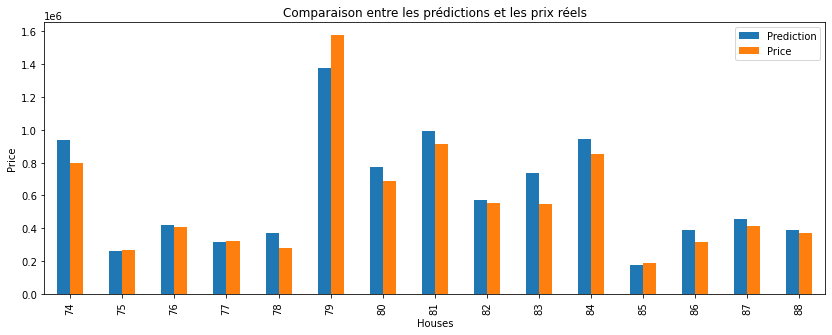

In [68]:
# Score en antilog : 
score2 = r2_score(exp_tru, exp_pred)
print('Score :', score2 )


df_pred = pd.DataFrame(exp_tru, exp_pred).reset_index()
df_pred.columns = ['Prediction', 'Price']
random = np.random.randint(0,df_pred.shape[0])
df_pred[random:random+15].plot.bar( figsize=(14,5))
plt.title('Comparaison entre les prédictions et les prix réels')
plt.xlabel('Houses')
plt.ylabel('Price')
plt.show()

Score avec les prix réels : 0.9062220984854346


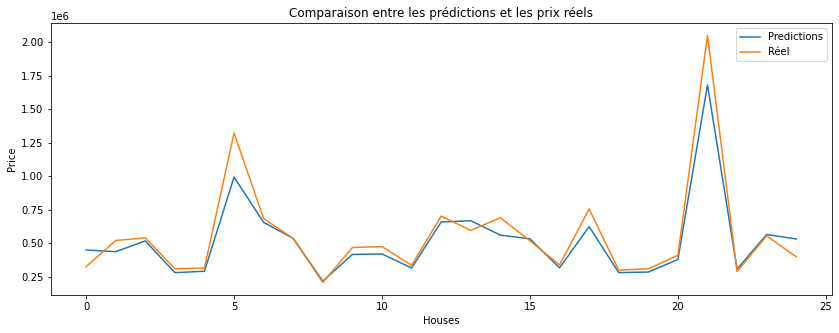

In [69]:
print('Score avec les prix réels :', score)
# Affichage de la courbe de correlation 

random = np.random.randint(0,df_pred.shape[0])
plt.figure(figsize=(14,5))
sns.lineplot(data = exp_pred[random:random + 25 ], label='Predictions' )
sns.lineplot(data = exp_tru[ random :random +25], label='Réel' )
plt.title('Comparaison entre les prédictions et les prix réels')
plt.xlabel('Houses')
plt.ylabel('Price')
plt.show()

In [23]:
# Datafram avec les predictions, les prix réel et la différence entre les deux avec un score personalisé  
score2 = r2_score(exp_tru, exp_pred)
print('Score :', score2 )

df_pred = pd.DataFrame(exp_tru, exp_pred).reset_index()
df_pred.columns = ['Prediction', 'Price']
df_pred['score'] = np.abs(((df_pred['Price'] - df_pred['Prediction'] ) / df_pred['Price']).round(4))
df_pred_2 = df_pred.reset_index().drop('index', axis=1)

df_pred_2.sort_values(by='score', ascending=False)

Score : 0.9062220984854346


,Prediction,Price,score
609,566456.8,257000.0,1.2041
874,634685.1,317625.0,0.9982
1060,302121.6,160797.0,0.8789
1111,201641.5,110000.0,0.8331
468,710389.4,402000.0,0.7671
...,...,...,...
1269,316868.4,317000.0,0.0004
1024,285048.3,285000.0,0.0002
463,311981.9,312000.0,0.0001
1191,402944.3,403000.0,0.0001


# On peut aussi essayer de les visualiser

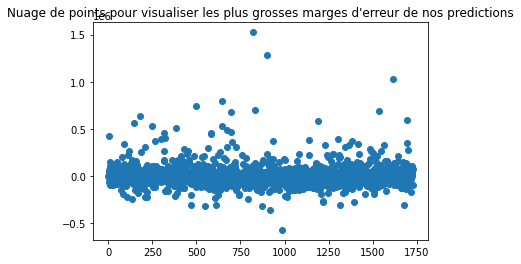

In [71]:
plt.scatter(df_pred_2['index'], df_pred_2['diff'])
plt.title('Nuage de points pour visualiser les plus grosses marges d\'erreur de nos predictions' )
plt.show()

/home/ayoub/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ayoub/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Prediction', ylabel='Price'>

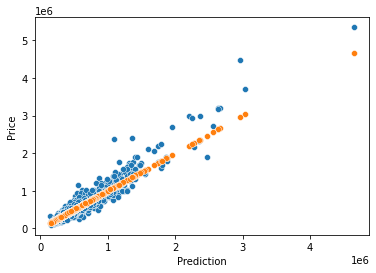

In [101]:
sns.scatterplot(df_pred_2['Prediction'], df_pred_2['Price'])
sns.scatterplot(df_pred_2['Prediction'], df_pred_2['Prediction'])

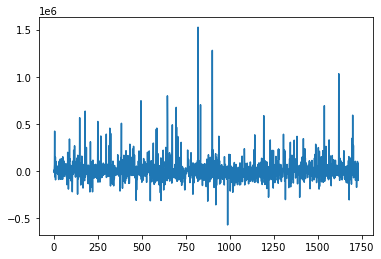

In [72]:
plt.plot(df_pred_2['diff'])
plt.show()

### Pour aller plus loin, on pourrait s'amuser à aller comprendre quels sont les maisons les moins bien apprises dans le modèle d'entrainements et s'ils correspondent à des outlayers.

In [85]:
np.argmax(df_pred_2['score'])

609

In [98]:
X_test.loc[609,:]

date                   2015
bedrooms                  4
bathrooms               3.5
sqft_living            3100
sqft_lot              15842
floors                  2.0
waterfront                0
view                      0
condition                 3
grade                     8
sqft_above                1
sqft_basement           700
yr_built               1996
yr_renovated              0
zipcode               98028
lat                 47.7466
long                122.242
sqft_living15          2200
sqft_lot15            19400
renoved_recently      False
family_house           True
Name: 609, dtype: object

In [100]:
df[(df['date'] == 2015) & (df['yr_built'] == 1996) & (df['bathrooms'] == 3.5) & (df['zipcode'] == 98028)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renoved_recently,family_house
609,2015,13.28788,4,3.5,3100,15842,2.0,0,0,3,8,1,700,1996,0,98028,47.7466,122.242,2200,19400,False,True


On pourrait aller plus loin mais je ne le ferai pas ici 

# - Learning curve

![image](learning.png)

<!-- <img src='learning.png' width="1100" height="400"> -->

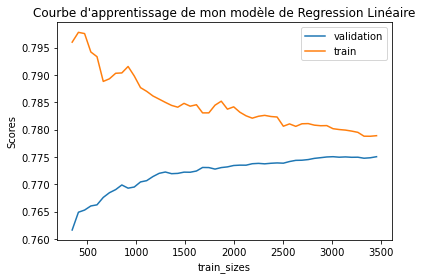

In [147]:
# Learning curve :  
k = np.linspace(0.1, 1, 50)
# k = np.linspace(0.1 , 1.0, 10) # On peut le faire en pourcentage 

N, train_score, val_score = learning_curve(model['linearregression'], X_test, y_test, train_sizes = k, cv=5, shuffle=True)
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.plot(N, train_score.mean(axis=1), label='train')    

plt.title('Courbe d\'apprentissage de mon modèle de Regression Linéaire')
plt.xlabel('train_sizes')
plt.ylabel('Scores')
plt.legend()
plt.show()

learning curve avec le model principal : 
![](learning_curve.png)

### Je retrouve les coefs de mon model pour les mettre dans un datafram 

Je n'ai pas trouvé meilleur solution que de les récupéré une par une dans les modeles

In [25]:
# Find my coefs : 

coef = model['linearregression'].coef_
pip_1_poly = model['columntransformer'].transformers_[0][1]['polynomialfeatures'].get_feature_names(X_train.columns)
pip_2_poly = model['columntransformer'].transformers_[2][1]['polynomialfeatures'].get_feature_names(X_train.columns)
one_hot_encoder_features = model['columntransformer'].transformers_[1][1]['onehotencoder'].get_feature_names()

print('Nombre de coef :', len(model['linearregression'].coef_))

columns = []
columns += pip_1_poly 
columns += pip_2_poly 
columns += list(one_hot_encoder_features)


coef_df = pd.DataFrame(coef , index=columns, columns=['coef'])
coef_df.sort_values(by=['coef'], ascending=False)[1:25]

Nombre de coef : 363


,coef
x0_98038,5.348651e+07
x0_98070,3.866612e+07
x0_98031,3.517974e+07
x0_98052,2.042659e+07
x0_98058,1.914679e+07
x0_98045,5.222519e+06
x0_98039,4.348019e+06
x3_4,4.211182e+06
sqft_lot waterfront,4.108289e+05
sqft_lot floors,4.107843e+05


Vous pourrez vérifier ces zipcode, il s'agit de chic département autour de Seattle. 

## Petit bonus 

## -Visualisation du datafram après transformation du preprocessor pour utiliser stat model

In [151]:
# Datafram avec ma data transformé 
x_train_t = preprocessor.fit_transform(X_train)
df_stat = pd.DataFrame(x_train_t)
df_stat.columns = columns
df_stat

,1,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,date^2,date bedrooms,date bathrooms,date sqft_living,date sqft_lot,date floors,date waterfront,date view,date condition,bedrooms^2,bedrooms bathrooms,bedrooms sqft_living,bedrooms sqft_lot,bedrooms floors,bedrooms waterfront,bedrooms view,bedrooms condition,bathrooms^2,bathrooms sqft_living,bathrooms sqft_lot,bathrooms floors,bathrooms waterfront,bathrooms view,bathrooms condition,sqft_living^2,sqft_living sqft_lot,sqft_living floors,sqft_living waterfront,sqft_living view,sqft_living condition,sqft_lot^2,sqft_lot floors,sqft_lot waterfront,sqft_lot view,sqft_lot condition,floors^2,floors waterfront,floors view,floors condition,waterfront^2,waterfront view,waterfront condition,view^2,view condition,condition^2,date^3,date^2 bedrooms,date^2 bathrooms,date^2 sqft_living,date^2 sqft_lot,date^2 floors,date^2 waterfront,date^2 view,date^2 condition,date bedrooms^2,date bedrooms bathrooms,date bedrooms sqft_living,date bedrooms sqft_lot,date bedrooms floors,date bedrooms waterfront,date bedrooms view,date bedrooms condition,date bathrooms^2,date bathrooms sqft_living,date bathrooms sqft_lot,date bathrooms floors,date bathrooms waterfront,date bathrooms view,date bathrooms condition,date sqft_living^2,date sqft_living sqft_lot,date sqft_living floors,date sqft_living waterfront,date sqft_living view,date sqft_living condition,date sqft_lot^2,date sqft_lot floors,date sqft_lot waterfront,date sqft_lot view,date sqft_lot condition,date floors^2,date floors waterfront,date floors view,date floors condition,date waterfront^2,date waterfront view,date waterfront condition,date view^2,date view condition,date condition^2,bedrooms^3,bedrooms^2 bathrooms,bedrooms^2 sqft_living,bedrooms^2 sqft_lot,bedrooms^2 floors,bedrooms^2 waterfront,bedrooms^2 view,bedrooms^2 condition,bedrooms bathrooms^2,bedrooms bathrooms sqft_living,bedrooms bathrooms sqft_lot,bedrooms bathrooms floors,bedrooms bathrooms waterfront,bedrooms bathrooms view,bedrooms bathrooms condition,bedrooms sqft_living^2,bedrooms sqft_living sqft_lot,bedrooms sqft_living floors,bedrooms sqft_living waterfront,bedrooms sqft_living view,bedrooms sqft_living condition,bedrooms sqft_lot^2,bedrooms sqft_lot floors,bedrooms sqft_lot waterfront,bedrooms sqft_lot view,bedrooms sqft_lot condition,bedrooms floors^2,bedrooms floors waterfront,bedrooms floors view,bedrooms floors condition,bedrooms waterfront^2,bedrooms waterfront view,bedrooms waterfront condition,bedrooms view^2,bedrooms view condition,bedrooms condition^2,bathrooms^3,bathrooms^2 sqft_living,bathrooms^2 sqft_lot,bathrooms^2 floors,bathrooms^2 waterfront,bathrooms^2 view,bathrooms^2 condition,bathrooms sqft_living^2,bathrooms sqft_living sqft_lot,bathrooms sqft_living floors,bathrooms sqft_living waterfront,bathrooms sqft_living view,bathrooms sqft_living condition,bathrooms sqft_lot^2,bathrooms sqft_lot floors,bathrooms sqft_lot waterfront,bathrooms sqft_lot view,bathrooms sqft_lot condition,bathrooms floors^2,bathrooms floors waterfront,bathrooms floors view,bathrooms floors condition,bathrooms waterfront^2,bathrooms waterfront view,bathrooms waterfront condition,bathrooms view^2,bathrooms view condition,bathrooms condition^2,sqft_living^3,sqft_living^2 sqft_lot,sqft_living^2 floors,sqft_living^2 waterfront,sqft_living^2 view,sqft_living^2 condition,sqft_living sqft_lot^2,sqft_living sqft_lot floors,sqft_living sqft_lot waterfront,sqft_living sqft_lot view,sqft_living sqft_lot condition,sqft_living floors^2,sqft_living floors waterfront,sqft_living floors view,sqft_living floors condition,sqft_living waterfront^2,sqft_living waterfront view,sqft_living waterfront condition,sqft_living view^2,sqft_living view condition,sqft_living condition^2,sqft_lot^3,sqft_lot^2 floors,sqft_lot^2 waterfront,sqft_lot^2 view,sqft_lot^2 condition,sqft_lot floors^2,sqft_lot floors waterfront,sqft_lot floors view,sqft_lot floors condition,sqft_lot waterfront^2,sqft_

## - J'utilise mon df transformé pour visualisé tout mes coefs 

In [152]:
# Stats model 
import numpy as np 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 

res = sm.OLS(y_train, df_stat).fit()
res.summary()

/home/ayoub/anaconda3/envs/IA/lib/python3.10/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     409.1
Date:                Thu, 10 Mar 2022   Prob (F-statistic):               0.00
Time:                        01:02:09   Log-Likelihood:                 5736.7
No. Observations:               15561   AIC:                        -1.081e+04
Df Residuals:                   15230   BIC:                            -8278.
Df Model:                         330                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
1                                    2.3315      0.003    931.835      0.000       2.327       2.336
date                                 0.2317      0.010     22.515      0.000       0.212       0.252
bedrooms                             0.0706      0.010      7.314      0.000       0.052       0.090
bathrooms                            0.0946      0.009      9.967      0.000       0.076       0.113
sqft_living                         -0.9716      0.314     -3.096      0.002      -1.587      -0.357
sqft_lot                             0.0161      0.011      1.460      0.144      -0.005       0.038
floors                              -0.0239      0.009     -2.541      0.011      -0.042      -0.005
waterfront                           0.4457      0.030     14.908      0.000       0.387       0.504
view                                 0.0308      0.028      1.103      0.270      -0.024       0.086
condition                            0.0105      0.022      0.486      0.627      -0.032       0.053
date^2                               0.0228      0.009      2.666      0.008       0.006       0.040
date bedrooms                       -0.0216      0.011     -1.883      0.060      -0.044       0.001
date bathrooms                       0.0142      0.012      1.218      0.223      -0.009       0.037
date sqft_living                    -0.0800      0.108     -0.739      0.460      -0.292       0.132
date sqft_lot                        0.0428      0.013      3.346      0.001       0.018       0.068
date floors                          0.0147      0.011      1.353      0.176      -0.007       0.036
date waterfront                     -0.0058      0.009     -0.626      0.531      -0.024       0.012
date view                            0.0410      0.013      3.054      0.002       0.015       0.067
date condition                      -0.0170      0.013     -1.276      0.202      -0.043       0.009
bedrooms^2                           0.0049      0.005      0.990      0.322      -0.005       0.015
bedrooms bathrooms                  -0.0332      0.011     -2.895      0.004      -0.056      -0.011
bedrooms sqft_living                 0.1736      0.072      2.398      0.017       0.032       0.316
bedrooms sqft_lot                    0.0150      0.012      1.278      0.201      -0.008       0.038
bedrooms floors                      0.0043      0.007      0.581      0.561      -0.010       0.019
bedrooms waterfront                  0.0132      0.009      1.457      0.145      -0.005       0.031
bedrooms view                       -0.0168      0.012     -1.399      0.162      -0.040       0.007
bedrooms condition                  -0.0071      0.014     -0.504      0.614      -0.035       0.021
bathrooms^2                         -0.0039      0.00